In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

In [3]:
train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [6]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [8]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [9]:
test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

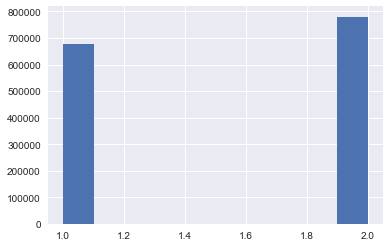

In [10]:
train['vendor_id'].hist()

In [11]:
train['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

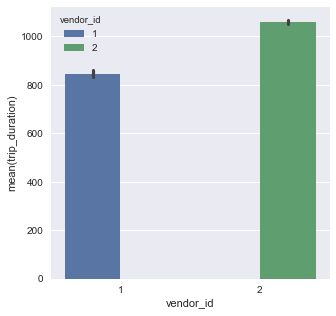

In [12]:
# vendorid having 2 seems to have a larger duration
fig,axes = plt.subplots(figsize = (5,5))
sns.barplot(data=train, x='vendor_id',y='trip_duration',hue='vendor_id')

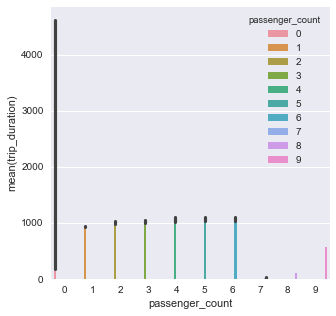

In [13]:
# Number of people fom 1 to 6 almost have same time to travel as opposed to 7 to 9.
fig,axes = plt.subplots(figsize = (5,5))
sns.barplot(data=train, x='passenger_count',y='trip_duration',hue='passenger_count')

In [14]:
train_corr = train.corr()
train_corr['trip_duration'].sort_values(ascending=False)

trip_duration        1.000000
pickup_longitude     0.026542
vendor_id            0.020304
dropoff_longitude    0.014678
passenger_count      0.008471
dropoff_latitude    -0.020677
pickup_latitude     -0.029204
Name: trip_duration, dtype: float64

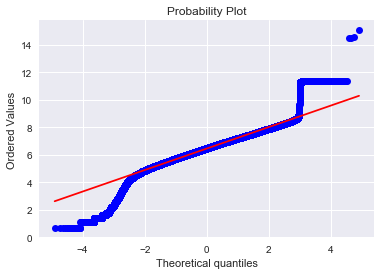

In [15]:
fig = plt.figure()
res = stats.probplot(np.log1p(train['trip_duration']), plot=plt)
plt.show()

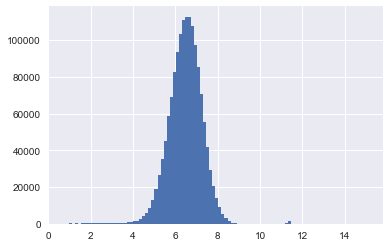

In [16]:
np.log1p(train['trip_duration']).hist(bins=100)

(array([  3.30000000e+01,   0.00000000e+00,   1.77000000e+02,
          0.00000000e+00,   3.18000000e+02,   0.00000000e+00,
          3.17000000e+02,   2.84000000e+02,   1.92000000e+02,
          2.18000000e+02,   2.06000000e+02,   4.21000000e+02,
          1.64000000e+02,   3.14000000e+02,   4.50000000e+02,
          2.77000000e+02,   5.24000000e+02,   4.02000000e+02,
          4.85000000e+02,   6.11000000e+02,   5.53000000e+02,
          8.32000000e+02,   9.16000000e+02,   1.43000000e+03,
          1.69300000e+03,   2.84800000e+03,   4.24500000e+03,
          6.00800000e+03,   8.77800000e+03,   1.29630000e+04,
          1.89590000e+04,   2.64870000e+04,   3.55110000e+04,
          4.50130000e+04,   5.88140000e+04,   6.89740000e+04,
          8.24950000e+04,   9.34350000e+04,   1.03080000e+05,
          1.11102000e+05,   1.12725000e+05,   1.12528000e+05,
          1.07650000e+05,   9.74220000e+04,   8.52740000e+04,
          7.07090000e+04,   5.56630000e+04,   4.15460000e+04,
        

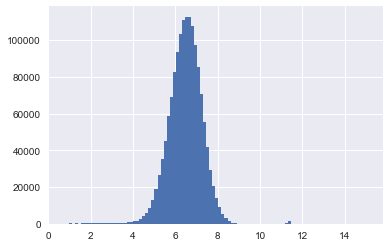

In [33]:
plt.hist(np.log1p(train['trip_duration']),bins=100)

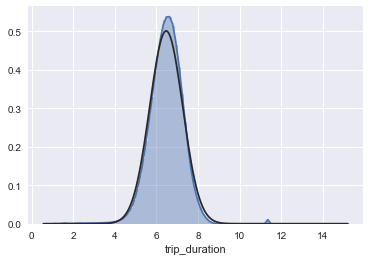

In [35]:
sns.distplot(a=np.log1p(train['trip_duration']),bins=100, fit=stats.norm)

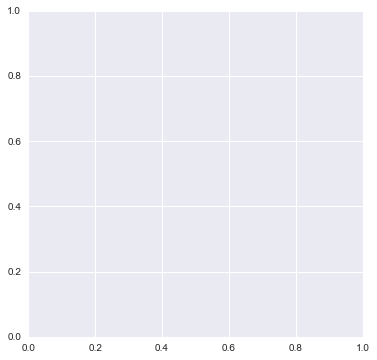

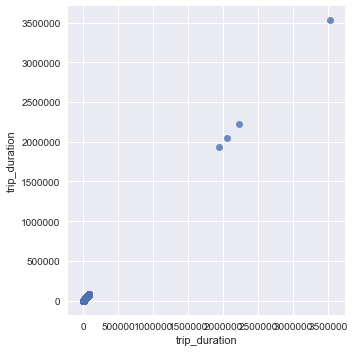

In [19]:
fig, axes = plt.subplots(figsize = (6,6))
sns.lmplot(x='trip_duration',y='trip_duration',data=train,fit_reg=False)